#Import Packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

###Create Nudge Function

- This will reproduce dataset 5 times bigger than the original
- Can be seen as another way of carrying out data augementation.

In [0]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

#Load Data

- Load the data from the keras dataset library
- convert to array of floating points numbers.
- Nudge the data.
- Sclae the dataset.
- Split into train and test.

In [0]:
# Load Data
X, Y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)


#Build The model.
- Instantiate both the logistice regression and RBM model
- Create a pipeline to run the model.

In [0]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

##Model Training
- Train the model on the assigned parameters.
- Fit the model on the train and test data.

In [6]:
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -27.63, time = 0.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -27.03, time = 0.08s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -25.98, time = 0.08s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -25.09, time = 0.08s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -23.97, time = 0.08s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -23.77, time = 0.09s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -23.52, time = 0.08s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -22.80, time = 0.07s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -22.38, time = 0.07s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -22.40, time = 0.08s


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)

#Evaluation
- Perform evaluation on the test data set.
- Print the classification report.

In [7]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.91      0.91      0.91        35
           2       1.00      0.86      0.93        36
           3       0.79      0.93      0.86        29
           4       0.85      0.97      0.91        30
           5       0.92      0.90      0.91        40
           6       0.98      0.98      0.98        44
           7       0.90      0.95      0.92        39
           8       0.94      0.87      0.91        39
           9       0.85      0.80      0.83        41

    accuracy                           0.91       360
   macro avg       0.92      0.92      0.91       360
weighted avg       0.92      0.91      0.91       360


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.91      0.89      0.90  

#Plot the components
- Here we will plot the rbm components.

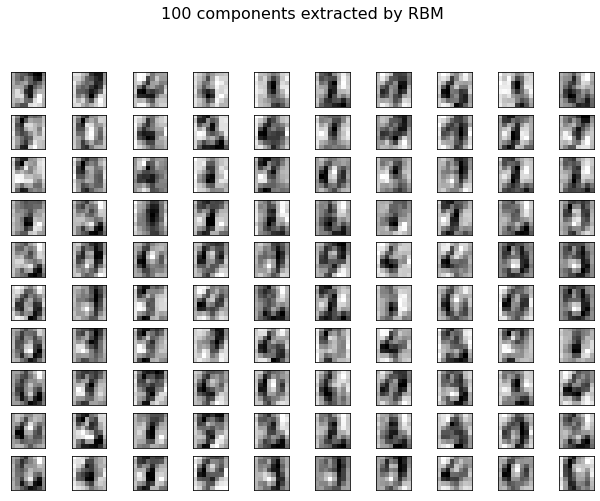

In [11]:
# Plotting

plt.figure(figsize=(10, 7))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

#Excercises

###Qustion 1. RBM stands for Restricted Boltzmann Machine
  - A) Flase
  - B) True

###Question 2. RBM has ____ number of layers.
  - A) 5
  - B) 3
  - C) 1
  - D) 2

###Question 3. Build a RBM model
- Complete the instantiation of the model and pipeline

In [0]:
# Models we will use
logistic = linear_model._____________(solver=______, tol=__)
rbm = _______(random_state=___, verbose=_______)

rbm_features_classifier = ________(
    steps=[(_________, _______), (_______, _________)])

###Question 4. Train the Model
- Complete the code to trian the model.

In [0]:
# Training

#assign hyperparameters of your choice
rbm.learning_rate = _____
rbm.n_iter =____


rbm.n_components = ___
logistic.C = ______

# Training RBM-Logistic Pipeline
rbm_features_classifier.___________(_____, _________)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = __________(_________)
raw_pixel_classifier.__________ = __________
raw_pixel_classifier.___________(_________, ___________)

###Question 5. Evaluate the Model
- Complete the code

In [0]:
# Evaluation

Y_pred = ________________________.________(__________)
print("Logistic regression using RBM features:\n%s\n" % (
    __________.__________________(__________, __________)))

Y_pred = ______________.____(________)
print("Logistic regression using raw pixel features:\n%s\n" % (
    ____________._____________(_______,_________)))

# Solution

###Question 1. 
- Solution = B- True

Question 2.  Solution
 - D) 2

###Question 3. Solution

In [0]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

###Question 4. Solution

In [0]:
# Training

rbm.learning_rate = 0.06
rbm.n_iter = 10


rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

###Question 5. Solution

In [0]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))